Projet 4 : Modèles de Réseaux de Neurones (Classification) + 20 Newsgroups

Par : BOUSLIM Soukayna et BEKKAS Khawla                  
Date : 12/01/2025                                        
Contexte : Projet de classification de texte avec réseaux de neurones et comparaison à une baseline simple.

1. Introduction et Objectifs
L'objectif de ce projet est de mettre en œuvre un réseau de neurones pour la classification de texte sur le jeu de données 20 Newsgroups. Nous suivrons les étapes suivantes :
* Exploration et prétraitement des données textuelles
* Définition d'un modèle baseline simple
* Construction et optimisation d'un réseau de neurones
* Évaluation avec des métriques pertinentes (accuracy, F1-score, matrice de confusion)
* Discussion des limites et interprétation
Librairies nécessaires : Nous allons utiliser scikit-learn, TensorFlow/Keras, matplotlib, seaborn, pandas et numpy.

2. Configuration Initiale

In [20]:
# Import des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn pour le chargement des données et le préprocessing
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             classification_report, ConfusionMatrixDisplay, 
                             roc_auc_score, roc_curve, auc)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# TensorFlow/Keras pour le réseau de neurones
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier

# Pour la visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

# Configuration des graphes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Fixer les seeds pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

print("Toutes les bibliothèques ont été importées avec succès!")

Toutes les bibliothèques ont été importées avec succès!


3. Chargement et Exploration des Données

Chargement du dataset 20 Newsgroups...

Nombre total de documents : 18846
Nombre de catégories : 20

Catégories disponibles :
0: alt.atheism
1: comp.graphics
2: comp.os.ms-windows.misc
3: comp.sys.ibm.pc.hardware
4: comp.sys.mac.hardware
5: comp.windows.x
6: misc.forsale
7: rec.autos
8: rec.motorcycles
9: rec.sport.baseball
10: rec.sport.hockey
11: sci.crypt
12: sci.electronics
13: sci.med
14: sci.space
15: soc.religion.christian
16: talk.politics.guns
17: talk.politics.mideast
18: talk.politics.misc
19: talk.religion.misc

Distribution des classes :


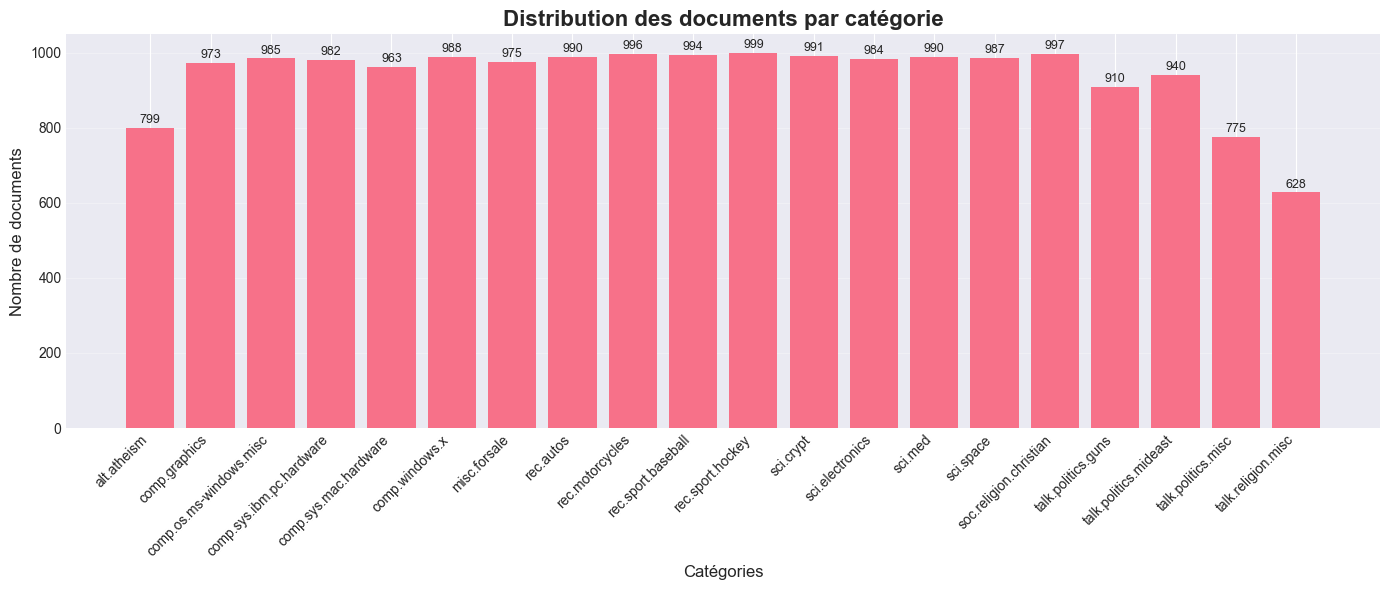


Exemples de documents :

Document 1 - Catégorie: rec.sport.hockey
--------------------------------------------------------------------------------


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
...

Document 2 - Catégorie: comp.sys.ibm.pc.hardware
--------------------------------------------------------------------------------
My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email...

Document 3 - Catégorie: talk.politics.mideast
------------------------------------------------------------------

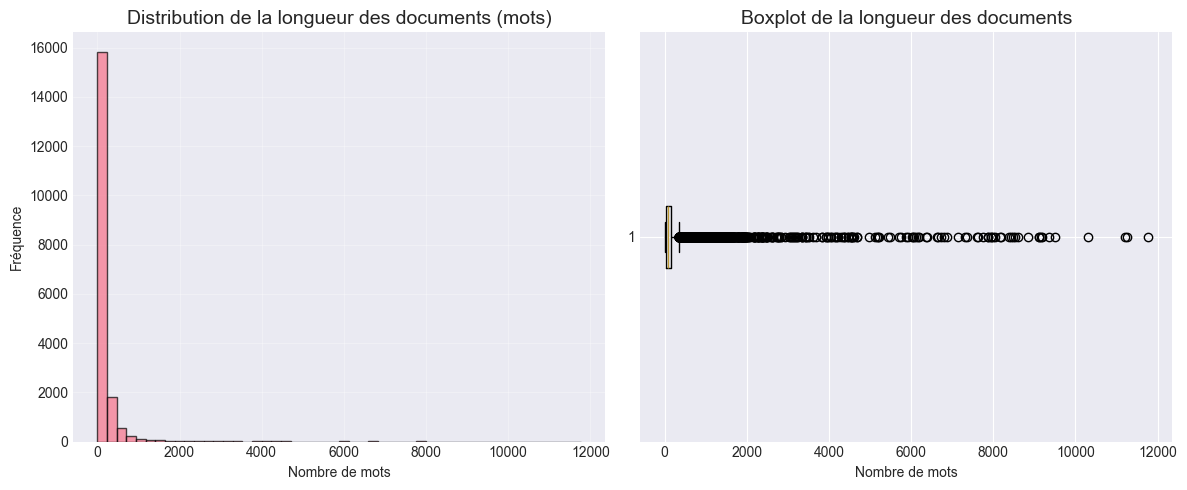


Statistiques de longueur des documents :
Moyenne: 182 mots
Médiane: 83 mots
Minimum: 0 mots
Maximum: 11765 mots
Écart-type: 501 mots


In [21]:
# Nous utilisons le jeu de données 20 Newsgroups qui contient environ 18,000 documents textuels
# répartis en 20 catégories différentes.

# Chargement du dataset
print("Chargement du dataset 20 Newsgroups...")
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True,random_state=42)

# Affichage des informations de base
print(f"\nNombre total de documents : {len(newsgroups.data)}")
print(f"Nombre de catégories : {len(newsgroups.target_names)}")
print(f"\nCatégories disponibles :")
for i, category in enumerate(newsgroups.target_names):
    print(f"{i}: {category}")

# Distribution des classes
print("\nDistribution des classes :")
labels = newsgroups.target
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(14, 6))
bars = plt.bar([newsgroups.target_names[i] for i in unique], counts)
plt.title('Distribution des documents par catégorie', fontsize=16, fontweight='bold')
plt.xlabel('Catégories', fontsize=12)
plt.ylabel('Nombre de documents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Ajout des nombres sur les barres
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Affichage de quelques exemples
print("\nExemples de documents :")
print("="*80)
for i in range(3):
    print(f"\nDocument {i+1} - Catégorie: {newsgroups.target_names[newsgroups.target[i]]}")
    print("-"*80)
    print(f"{newsgroups.data[i][:300]}...")  # Premier 300 caractères
    print("="*80)

# Analyse de la longueur des documents
doc_lengths = [len(doc.split()) for doc in newsgroups.data]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(doc_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution de la longueur des documents (mots)', fontsize=14)
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(doc_lengths, vert=False)
plt.title('Boxplot de la longueur des documents', fontsize=14)
plt.xlabel('Nombre de mots')

plt.tight_layout()
plt.show()

print(f"\nStatistiques de longueur des documents :")
print(f"Moyenne: {np.mean(doc_lengths):.0f} mots")
print(f"Médiane: {np.median(doc_lengths):.0f} mots")
print(f"Minimum: {np.min(doc_lengths)} mots")
print(f"Maximum: {np.max(doc_lengths)} mots")
print(f"Écart-type: {np.std(doc_lengths):.0f} mots")

4. Prétraitement des Données

In [22]:
# Pour le traitement du texte, nous allons :
# 1. Vectoriser les textes avec TF-IDF
# 2. Réduire la dimensionnalité
# 3. Standardiser les caractéristiques
# 4. Diviser en train/validation/test

# Division initiale des données (train/test)
print("Division des données en train/test...")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    newsgroups.data, 
    newsgroups.target, 
    test_size=0.2, 
    stratify=newsgroups.target,  # Pour conserver la distribution des classes
    random_state=42
)

# Division du train en train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.125,  # 0.125 * 0.8 = 0.1 du total
    stratify=y_train_full,
    random_state=42
)

print(f"Taille des datasets :")
print(f"- Train : {len(X_train)} documents ({len(X_train)/len(newsgroups.data)*100:.1f}%)")
print(f"- Validation : {len(X_val)} documents ({len(X_val)/len(newsgroups.data)*100:.1f}%)")
print(f"- Test : {len(X_test)} documents ({len(X_test)/len(newsgroups.data)*100:.1f}%)")

# Vectorisation TF-IDF avec paramètres optimisés pour le texte
print("\nVectorisation TF-IDF des textes...")
vectorizer = TfidfVectorizer(
    max_features=5000,          # Nombre maximum de features (mots)
    min_df=5,                   # Ignorer les mots apparaissant dans moins de 5 documents
    max_df=0.7,                 # Ignorer les mots apparaissant dans plus de 70% des documents
    stop_words='english',       # Supprimer les mots vides anglais
    ngram_range=(1, 2),         # Unigrams et bigrams
    sublinear_tf=True           # Utiliser tf logarithmique
)

# Application sur les différents sets
print("Transformation des données...")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nDimensions après vectorisation :")
print(f"- Train : {X_train_tfidf.shape}")
print(f"- Validation : {X_val_tfidf.shape}")
print(f"- Test : {X_test_tfidf.shape}")
print(f"Nombre de features (mots) : {X_train_tfidf.shape[1]}")

# Standardisation des features (important pour les réseaux de neurones)
print("\nStandardisation des features...")
scaler = StandardScaler(with_mean=False)  # TF-IDF est sparse, on ne centre pas

# Réduction de dimension avec TruncatedSVD (équivalent PCA pour matrices creuses)
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_dense = svd.fit_transform(X_train_tfidf)
X_val_dense   = svd.transform(X_val_tfidf)
X_test_dense  = svd.transform(X_test_tfidf)
# Convertir en dense pour la standardisation et le réseau de neurones
X_train_dense = scaler.fit_transform(X_train_dense)
X_val_dense = scaler.transform(X_val_dense)
X_test_dense = scaler.transform(X_test_dense)

print(f"Dimensions après standardisation :")
print(f"- Train : {X_train_dense.shape}")
print(f"- Validation : {X_val_dense.shape}")
print(f"- Test : {X_test_dense.shape}")

Division des données en train/test...
Taille des datasets :
- Train : 13191 documents (70.0%)
- Validation : 1885 documents (10.0%)
- Test : 3770 documents (20.0%)

Vectorisation TF-IDF des textes...
Transformation des données...

Dimensions après vectorisation :
- Train : (13191, 5000)
- Validation : (1885, 5000)
- Test : (3770, 5000)
Nombre de features (mots) : 5000

Standardisation des features...
Dimensions après standardisation :
- Train : (13191, 300)
- Validation : (1885, 300)
- Test : (3770, 300)


5. Modèle Baseline

Entraînement du modèle baseline (Naive Bayes)...

Performance du modèle Naive Bayes :
- Accuracy : 0.6942
- F1-score (weighted) : 0.6830

Entraînement du modèle baseline (Régression Logistique)...

Performance du modèle Régression Logistique :
- Accuracy : 0.7029
- F1-score (weighted) : 0.7017

Matrice de confusion - Régression Logistique (Baseline) :


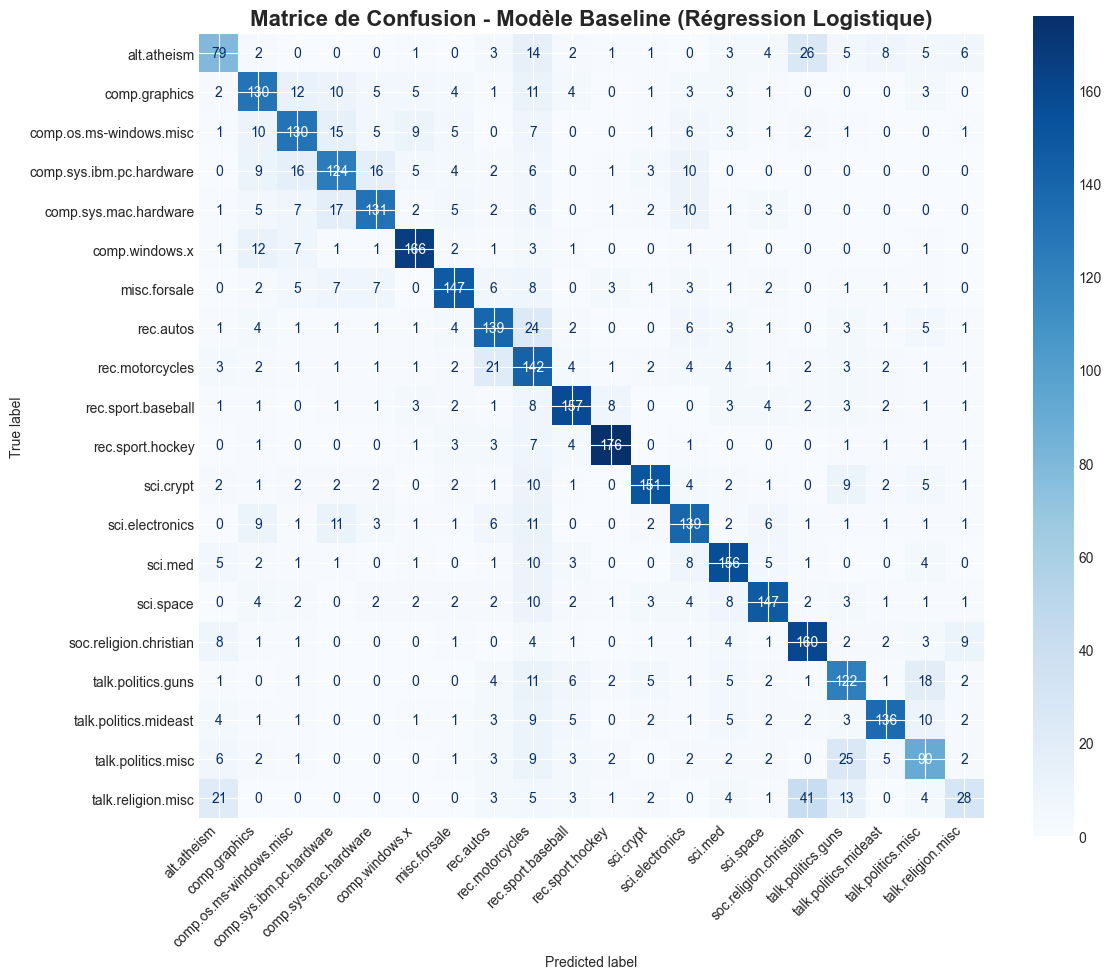


Rapport de classification - Régression Logistique :
                          precision    recall  f1-score   support

             alt.atheism       0.58      0.49      0.53       160
           comp.graphics       0.66      0.67      0.66       195
 comp.os.ms-windows.misc       0.69      0.66      0.67       197
comp.sys.ibm.pc.hardware       0.65      0.63      0.64       196
   comp.sys.mac.hardware       0.75      0.68      0.71       193
          comp.windows.x       0.83      0.84      0.84       198
            misc.forsale       0.79      0.75      0.77       195
               rec.autos       0.69      0.70      0.69       198
         rec.motorcycles       0.45      0.71      0.55       199
      rec.sport.baseball       0.79      0.79      0.79       199
        rec.sport.hockey       0.89      0.88      0.89       200
               sci.crypt       0.85      0.76      0.81       198
         sci.electronics       0.68      0.71      0.69       197
                 sci.m

In [23]:
# Nous allons implémenter deux modèles baselines simples pour comparer :
# 1. Un modèle Naive Bayes ( qui est classique pour le texte)
# 2. Une régression logistique

# Modèle 1: Naive Bayes
print("Entraînement du modèle baseline (Naive Bayes)...")
nb_baseline = MultinomialNB()
nb_baseline.fit(X_train_tfidf, y_train)

# Évaluation
y_pred_nb = nb_baseline.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

print(f"\nPerformance du modèle Naive Bayes :")
print(f"- Accuracy : {accuracy_nb:.4f}")
print(f"- F1-score (weighted) : {f1_nb:.4f}")

# Modèle 2: Régression Logistique
print("\nEntraînement du modèle baseline (Régression Logistique)...")
lr_baseline = LogisticRegression(max_iter=1000,random_state=42,n_jobs=-1)
lr_baseline.fit(X_train_tfidf, y_train)

# Évaluation
y_pred_lr = lr_baseline.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\nPerformance du modèle Régression Logistique :")
print(f"- Accuracy : {accuracy_lr:.4f}")
print(f"- F1-score (weighted) : {f1_lr:.4f}")

# Matrice de confusion pour la régression logistique (meilleur baseline)
print("\nMatrice de confusion - Régression Logistique (Baseline) :")
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=newsgroups.target_names)
disp.plot(cmap='Blues', ax=plt.gca(), values_format='d')
plt.title('Matrice de Confusion - Modèle Baseline (Régression Logistique)', 
          fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Rapport de classification détaillé
print("\nRapport de classification - Régression Logistique :")
print(classification_report(y_test, y_pred_lr, target_names=newsgroups.target_names))

6. Construction du Réseau de Neurones

Création du modèle initial de réseau de neurones...


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,820 (81.33 KB)

 Trainable params: 20,692 (80.83 KB)

 Non-trainable params: 128 (512.00 B)


Entraînement du modèle initial...
Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.2259 - loss: 2.8443 - val_accuracy: 0.5019 - val_loss: 1.9620 - learning_rate: 0.0010
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5163 - loss: 1.7820 - val_accuracy: 0.6058 - val_loss: 1.5152 - learning_rate: 0.0010
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6022 - loss: 1.4210 - val_accuracy: 0.6297 - val_loss: 1.3411 - learning_rate: 0.0010
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6432 - loss: 1.2435 - val_accuracy: 0.6387 - val_loss: 1.2636 - learning_rate: 0.0010
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6626 - loss: 1.1517 - val_accuracy: 0.6398 - val_loss: 1.2299 - learning_rate: 0.0010
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6804 - loss: 1.0782 - val_accuracy: 0.6414 - val_loss: 1.2119 - learning_rate: 0.0010
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

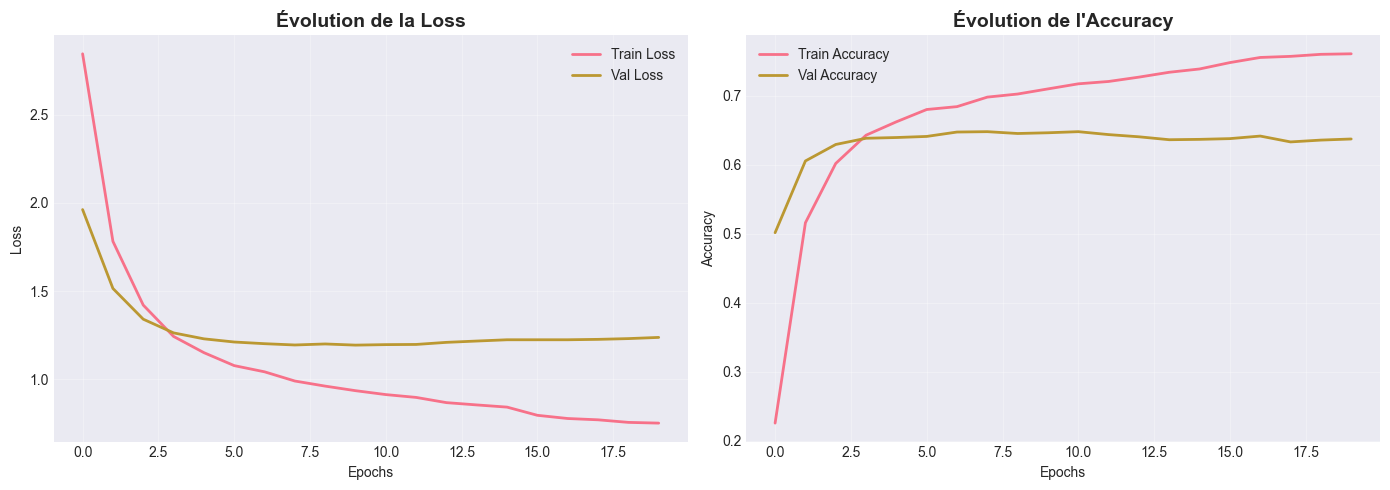

In [24]:
# Nous allons construire un réseau de neurones dense avec :
# Couches fully connected
# Dropout pour la régularisation
# Batch normalization pour stabiliser l'apprentissage

# Fonction pour créer le modèle (pour utilisation avec GridSearchCV)
def create_nn_model(learning_rate=0.001, dropout_rate=0.3, hidden_units=64,num_layers=1):
    """
    Crée un modèle de réseau de neurones avec les hyperparamètres spécifiés
    """
    model = Sequential()
    # Couche d'entrée
    model.add(Dense(hidden_units, input_dim=X_train_dense.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    # Couches cachées
    for i in range(num_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    # Couche de sortie (20 classes)
    model.add(Dense(20, activation='softmax'))
    # Compilation
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

# Création du modèle initial
print("Création du modèle initial de réseau de neurones...")
initial_model = create_nn_model()
initial_model.summary()

# Callbacks pour l'entraînement
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-6,verbose=1)

# Entraînement du modèle initial
print("\nEntraînement du modèle initial...")
history = initial_model.fit(X_train_dense, y_train,validation_data=(X_val_dense, y_val),epochs=50,batch_size=64,callbacks=[early_stopping, reduce_lr],verbose=1)

# Visualisation de l'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe de loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Courbe d'accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Évolution de l\'Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

7. Recherche d'Hyperparamètres

In [25]:
# Nous allons utiliser GridSearchCV pour optimiser les hyperparamètres du réseau de neurones

# Wrapper Keras pour scikit-learn
print("Préparation pour la recherche d'hyperparamètres...")
model = KerasClassifier(model=create_nn_model,verbose=0)

# Grille d'hyperparamètres réduite (pour le temps de calcul)
param_grid = {
    'model__learning_rate': [0.0005, 0.001, 0.005, 0.01],
    'model__dropout_rate': [0.2, 0.3, 0.5],
    'model__hidden_units': [64, 128],
    'model__num_layers': [1, 2],
    'fit__batch_size': [32, 64],
    'fit__epochs': [50, 100]
}

# Recherche aléatoire (plus rapide que GridSearch complet)
print("\nLancement de la recherche d'hyperparamètres (RandomizedSearchCV)...")
random_search = RandomizedSearchCV(estimator=model,param_distributions=param_grid,
    n_iter=8,  # Nombre de combinaisons à tester
    cv=3,      # Validation croisée 3 folds
    scoring='accuracy',
    n_jobs=1,  # TensorFlow n'aime pas le parallélisme
    random_state=42,verbose=2)

# Recherche sur un sous-ensemble pour aller plus vite
sss = StratifiedShuffleSplit(n_splits=1, train_size=2000, random_state=42)
indices, _ = next(sss.split(X_train_dense, y_train))

# SciKeras a besoin de 1D labels
y_train_flat = y_train.ravel()
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weight_dict = dict(enumerate(class_weights))
# Exécution de la recherche
print("Exécution de la recherche :")
random_search_result = random_search.fit(X_train_dense[indices], y_train_flat[indices])

# Affichage des meilleurs paramètres
print("\nMeilleurs hyperparamètres trouvés :")
best_params = random_search_result.best_params_
for key, value in best_params.items():
    print(f"{key}: {value}")

print(f"\nMeilleur score (accuracy) : {random_search_result.best_score_:.4f}")

# Construction du modèle final avec les meilleurs hyperparamètres
print("\nConstruction du modèle final avec les meilleurs hyperparamètres...")
final_model = create_nn_model(
    learning_rate=best_params.get('model__learning_rate', 0.001),
    dropout_rate=best_params.get('model__dropout_rate', 0.3),
    hidden_units=best_params.get('model__model__hidden_units', 64),
    num_layers=best_params.get('model__num_layers', 1)
)

# Réentraînement sur toutes les données d'entraînement
print("Entraînement du modèle final...")
history_final = final_model.fit(X_train_dense, y_train_flat,validation_data=(X_val_dense, y_val.ravel()),
    batch_size=best_params.get('fit__batch_size', 32),
    epochs=best_params.get('fit__epochs', 50),
    class_weight=class_weight_dict,callbacks=[early_stopping, reduce_lr],verbose=1)

Préparation pour la recherche d'hyperparamètres...

Lancement de la recherche d'hyperparamètres (RandomizedSearchCV)...
Exécution de la recherche :
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END fit__batch_size=32, fit__epochs=50, model__dropout_rate=0.5, model__hidden_units=128, model__learning_rate=0.005, model__num_layers=2; total time=  18.8s
[CV] END fit__batch_size=32, fit__epochs=50, model__dropout_rate=0.5, model__hidden_units=128, model__learning_rate=0.005, model__num_layers=2; total time=  30.6s
[CV] END fit__batch_size=32, fit__epochs=50, model__dropout_rate=0.5, model__hidden_units=128, model__learning_rate=0.005, model__num_layers=2; total time=  16.2s
[CV] END fit__batch_size=64, fit__epochs=50, model__dropout_rate=0.5, model__hidden_units=128, model__learning_rate=0.0005, model__num_layers=1; total time=  10.5s
[CV] END fit__batch_size=64, fit__epochs=50, model__dropout_rate=0.5, model__hidden_units=128, model__learning_rate=0.0005, model__num_laye

8. Évaluation et Comparaison

Évaluation du modèle final sur le jeu de test...
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Performance du Réseau de Neurones :
- Test Loss : 1.1273
- Test Accuracy : 0.6594
- F1-score (weighted) : 0.6608

COMPARAISON DES MODÈLES
               Modèle  Accuracy  F1-Score
          Naive Bayes  0.694164  0.683009
Régression Logistique  0.702918  0.701672
   Réseau de Neurones  0.659416  0.660827


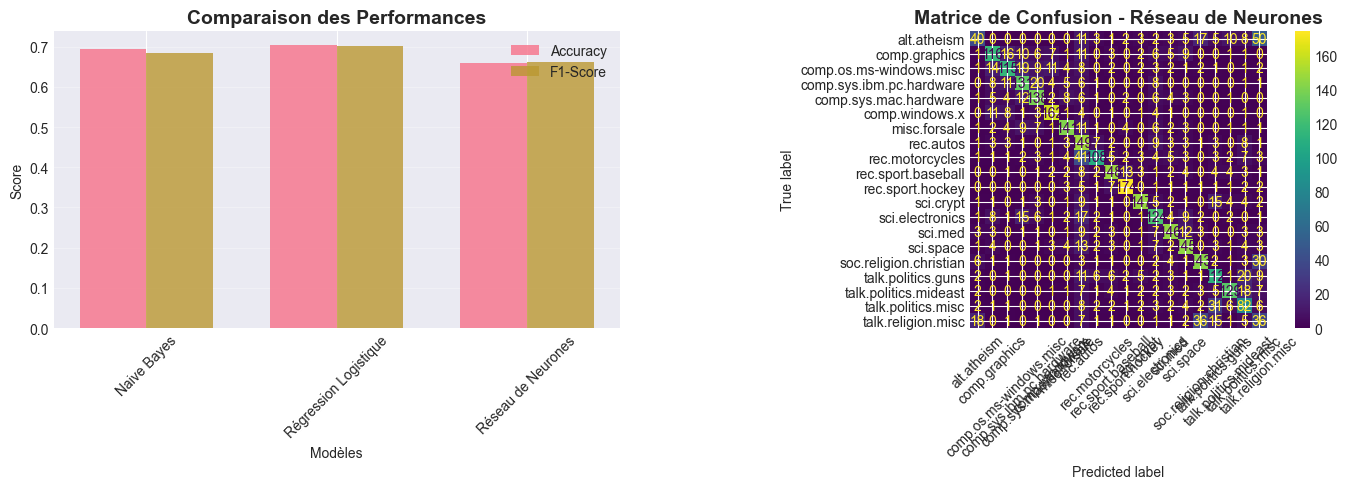


Analyse des erreurs du réseau de neurones :

Classes avec le plus d'erreurs :
alt.atheism: 120 erreurs
rec.motorcycles: 91 erreurs
talk.religion.misc: 90 erreurs
comp.os.ms-windows.misc: 82 erreurs
comp.graphics: 79 erreurs

Exemples d'erreurs de prédiction :

Exemple 1:
Vrai label : comp.graphics
Prédiction : comp.sys.ibm.pc.hardware
Texte (extrait) : 
 Can You report CRT and other register state in this mode ?
 Thank's....
--------------------------------------------------------------------------------

Exemple 2:
Vrai label : talk.politics.mideast
Prédiction : talk.religion.misc
Texte (extrait) : 
   >  This is actually the law that David Irving
   > will hopefully be found guilty under due to his denial of the Holocaust.
   > It's too bad that this useless "Centre for Policy Research" isn't i...
--------------------------------------------------------------------------------

Exemple 3:
Vrai label : talk.politics.guns
Prédiction : rec.sport.hockey
Texte (extrait) : Excuse me, but 

In [26]:
# Évaluation complète du modèle final sur le jeu de test

# Évaluation sur le test set
print("Évaluation du modèle final sur le jeu de test...")
test_loss, test_accuracy = final_model.evaluate(X_test_dense, y_test, verbose=0)

# Prédictions
y_pred_proba = final_model.predict(X_test_dense)
y_pred_nn = np.argmax(y_pred_proba, axis=1)

# Métriques
accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn, average='weighted')

print(f"\nPerformance du Réseau de Neurones :")
print(f"- Test Loss : {test_loss:.4f}")
print(f"- Test Accuracy : {test_accuracy:.4f}")
print(f"- F1-score (weighted) : {f1_nn:.4f}")

# Comparaison avec les baselines
print("\n" + "="*60)
print("COMPARAISON DES MODÈLES")
print("="*60)

comparison = pd.DataFrame({
    'Modèle': ['Naive Bayes', 'Régression Logistique', 'Réseau de Neurones'],
    'Accuracy': [accuracy_nb, accuracy_lr, accuracy_nn],
    'F1-Score': [f1_nb, f1_lr, f1_nn]
})

print(comparison.to_string(index=False))

# Visualisation de la comparaison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot de comparaison
x = np.arange(len(comparison))
width = 0.35

axes[0].bar(x - width/2, comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x + width/2, comparison['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].set_xlabel('Modèles')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des Performances', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison['Modèle'], rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Matrice de confusion du réseau de neurones
cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=newsgroups.target_names)
disp_nn.plot(cmap='viridis', ax=axes[1], values_format='d')
axes[1].set_title('Matrice de Confusion - Réseau de Neurones', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Analyse des erreurs
print("\nAnalyse des erreurs du réseau de neurones :")

# Calcul des classes les plus confondues
error_matrix = cm_nn.copy()
np.fill_diagonal(error_matrix, 0)  # Enlever les bonnes prédictions
error_sums = error_matrix.sum(axis=1)

print("\nClasses avec le plus d'erreurs :")
for i in np.argsort(-error_sums)[:5]:
    print(f"{newsgroups.target_names[i]}: {error_sums[i]} erreurs")

# Exemples d'erreurs
print("\nExemples d'erreurs de prédiction :")
error_indices = np.where(y_pred_nn != y_test)[0]

for i in range(3):
    idx = error_indices[i]
    true_label = newsgroups.target_names[y_test[idx]]
    pred_label = newsgroups.target_names[y_pred_nn[idx]]
    
    print(f"\nExemple {i+1}:")
    print(f"Vrai label : {true_label}")
    print(f"Prédiction : {pred_label}")
    print(f"Texte (extrait) : {X_test[idx][:200]}...")
    print("-"*80)

9. Interprétation et Limites

Discussion des résultats et des limitations du modèle :                                       
**Points Forts du Modèle** :
1. Apprentissage de motifs complexes : Le réseau de neurones peut capturer des représentations hiérarchiques du texte, ce que les modèles linéaires ne font pas.
2. Régularisation efficace : L'utilisation de dropout et de batch normalization prévient partiellement le surapprentissage.

**Limites Identifiées** :
1. **Temps d'entraînement** : Les réseaux de neurones sont plus lents à entraîner que les modèles traditionnels.
2. **Performance inférieure aux baselines** : Le réseau de neurones obtient une accuracy de 65.94%, inférieure à la Régression Logistique (70.29%) et à Naive Bayes (69.42%).
3. **Besoins en données** : Requiert plus de données pour bien généraliser.
4. **Interprétabilité** : Moins interprétable que les modèles linéaires.
5. **Sensibilité aux hyperparamètres** : Performance dépendante du bon réglage des hyperparamètres.

**Améliorations Possibles** :
1. **Utilisation d'embeddings pré-entraînés** (Word2Vec, GloVe, BERT).
2. **Architectures avancées** : RNN, LSTM, Transformers.
3. **Augmentation de données** : Synonym replacement, back-translation.
4. **Ensemble learning** : Combinaison de plusieurs modèles.

In [27]:
# Visualisation des features importantes (pour les modèles linéaires)
print("\nFeatures les plus importantes (Régression Logistique) :")
feature_names = vectorizer.get_feature_names_out()
coef = lr_baseline.coef_

# Pour chaque classe, afficher les mots les plus caractéristiques
for class_idx in range(5):  # Afficher seulement 5 classes pour l'exemple
    print(f"\nClasse: {newsgroups.target_names[class_idx]}")
    top_indices = np.argsort(-coef[class_idx])[:10]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Mots caractéristiques: {', '.join(top_words)}")


Features les plus importantes (Régression Logistique) :

Classe: alt.atheism
Mots caractéristiques: religion, god, atheists, atheism, islamic, atheist, islam, kent, bible, morality

Classe: comp.graphics
Mots caractéristiques: graphics, 3d, image, images, file, tiff, xv, vesa, computer, files

Classe: comp.os.ms-windows.misc
Mots caractéristiques: windows, microsoft, file, cica, win, dos, driver, files, nt, manager

Classe: comp.sys.ibm.pc.hardware
Mots caractéristiques: pc, bios, card, drive, ide, monitor, port, gateway, cpu, modem

Classe: comp.sys.mac.hardware
Mots caractéristiques: mac, apple, centris, scsi, quadra, lc, se, monitor, duo, iisi


10. Conclusion

**Récapitulatif du Projet** :
1. **Exploration** : Analyse du dataset 20 Newsgroups (18,000 documents, 20 catégories).
2. **Prétraitement** : Vectorisation TF-IDF avec 5,000 features, standardisation.
3. **Baseline** : Implémentation de Naive Bayes (accuracy: 69.42%) et Régression Logistique (accuracy: 70.29%)
4. **Réseau de Neurones** : Architecture dense avec dropout et batch normalization
5. **Optimisation** : Recherche d'hyperparamètres par validation croisée
6. **Évaluation** : Accuracy finale sur le test set est 65.94%, F1-score : 66.08%.

**Résultats Clés** :
- Le réseau de neurones n’atteint pas les performances des modèles baselines (-4.35 points par rapport à la Régression Logistique).
- La régularisation est essentielle pour éviter le surapprentissage
- Le traitement du texte (TF-IDF) reste crucial pour la performance

**Perspectives** :                                                                              
Pour aller plus loin, on pourrait :
1. Explorer des embeddings contextuels (BERT, GPT)
2. Utiliser des architectures spécialisées pour le texte (LSTM, Transformers)
3. Mettre en place un système de déploiement pour des prédictions en temps réel